In [2]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import copy

## Download Data

In [3]:
all_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor()
    ])

fashion_mnist_train = torchvision.datasets.FashionMNIST(root="fmnist/", download=False, transform=all_transforms)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root="fmnist/", download=False, transform=all_transforms, train=False)

## Construct Splits

In [4]:
fashion_mnist_train_splits = [torch.utils.data.Subset(fashion_mnist_train, torch.where(fashion_mnist_train.train_labels == i)[0]) for i in range(10)]
fashion_mnist_test_splits = [torch.utils.data.Subset(fashion_mnist_test, torch.where(fashion_mnist_test.train_labels == i)[0]) for i in range(10)]

/Users/sebastianlee/envs/cata/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [17]:
# fashion_mnist_train_split_dataloaders = [torch.utils.data.DataLoader(fashion_mnist_split, batch_size=1, shuffle=True) for fashion_mnist_split in fashion_mnist_train_splits]
# fashion_mnist_test_split_dataloaders = [torch.utils.data.DataLoader(fashion_mnist_split, batch_size=1, shuffle=True) for fashion_mnist_split in fashion_mnist_test_splits]

## Dataset Interpolation

In [5]:
def _get_dataset_mix(first_binary_classification_dataset, second_binary_classification_dataset, alpha: float):
    """OLD: Mixing on probability of sampling"""
    random_indices_subset_1 = torch.bernoulli(alpha * torch.ones(len(first_binary_classification_dataset)))
    random_indices_subset_2 = torch.bernoulli((1 - alpha) * torch.ones(len(second_binary_classification_dataset)))
    subset_1 = torch.utils.data.Subset(first_binary_classification_dataset, torch.where(random_indices_subset_1)[0])
    subset_2 = torch.utils.data.Subset(second_binary_classification_dataset, torch.where(random_indices_subset_2)[0])
    concatenated_dataset = torch.utils.data.ConcatDataset([subset_1, subset_2])
    return concatenated_dataset

In [11]:
dataset_05 = torch.utils.data.ConcatDataset([fashion_mnist_train_splits[0], fashion_mnist_train_splits[5]])
dataset_27 = torch.utils.data.ConcatDataset([fashion_mnist_train_splits[2], fashion_mnist_train_splits[7]])

dataset_05_test = torch.utils.data.ConcatDataset([fashion_mnist_test_splits[0], fashion_mnist_test_splits[5]])
dataset_27_test = torch.utils.data.ConcatDataset([fashion_mnist_test_splits[2], fashion_mnist_test_splits[7]])

dataloader_05 = torch.utils.data.DataLoader(dataset_05, batch_size=1, shuffle=True)
dataloader_05_test = torch.utils.data.DataLoader(dataset_05_test, batch_size=1, shuffle=True)

dataloader_27 = torch.utils.data.DataLoader(dataset_27, batch_size=1, shuffle=True)
dataloader_27_test = torch.utils.data.DataLoader(dataset_27_test, batch_size=1, shuffle=True)

target_mapping = {0: torch.Tensor([-1.]), 5: torch.Tensor([1.]), 2: torch.Tensor([-1.]),7: torch.Tensor([1.])}
label_mapping = {0: -1, 5: 1, 2: -1, 7: 1}

## Define Network

In [7]:
input_dim = 32 * 32

class Network(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self._layer1 = nn.Linear(input_dim, 8)
        
        self._layer2a = nn.Linear(8, 1)
        self._layer2b = nn.Linear(8, 1)
        
        self._task = 0
        
    def switch(self, task_index):
        self._task = task_index
        
    def forward(self, x):
        
        x = x.reshape(x.shape[0], -1)
        
        x = F.relu(self._layer1(x))
        
        if self._task == 0:
            y = self._layer2a(x)
        elif self._task == 1:
            y = self._layer2b(x)
        
        return y

## Training Loop

In [8]:
def train(dataloader_1, dataloader_2, alpha, network, epochs, lr, target_mapping, verbose=False):
    
    loss_function = nn.MSELoss()
    optimiser = torch.optim.SGD(params=network.parameters(), lr=lr)
    
    losses = []
    
    for e in range(epochs):
        
        epoch_loss = []
        
        for (x_1, y_1), (x_2, y_2) in zip(iter(dataloader_1), iter(dataloader_2)):
            
            mixed_input = alpha * x_1 + (1 - alpha) * x_2
            
            mapped_y_1 = target_mapping[y_1.item()]
            mapped_y_2 = target_mapping[y_2.item()]
            
            mixed_label = torch.Tensor([np.sign(alpha * mapped_y_1 + (1 - alpha) * mapped_y_2)])
            
            prediction = network(mixed_input)
            loss = loss_function(prediction.flatten(), mixed_label)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
                    
            epoch_loss.append(loss.item())
        
        if verbose:
            print(f"Epoch {e + 1}/{epochs} loss: {np.mean(epoch_loss)}")
        losses.append(np.mean(epoch_loss))
            
    return losses, network

## Test Loop

In [9]:
def test(dataloader_1, dataloader_2, alpha, network, target_mapping):
    
    loss_function = nn.MSELoss()
    
    test_loss = []
    correct_instances = []
    
    with torch.no_grad():

        for (x_1, y_1), (x_2, y_2) in zip(iter(dataloader_1), iter(dataloader_2)):

            mixed_input = alpha * x_1 + (1 - alpha) * x_2

            mapped_y_1 = target_mapping[y_1.item()]
            mapped_y_2 = target_mapping[y_2.item()]

            mixed_label = torch.Tensor([np.sign(alpha * mapped_y_1 + (1 - alpha) * mapped_y_2)])

            prediction = network(mixed_input)
            loss = loss_function(prediction.flatten(), mixed_label)
            correct = (torch.sign(prediction) == mixed_label).item()

            test_loss.append(loss.item())
            correct_instances.append(correct)

    return np.mean(test_loss), sum(correct_instances) / len(correct_instances)

## Task 1 Training

In [12]:
losses, task_1_trained_network = train(dataloader_05, dataloader_27, 1, Network(), 100, 0.01, target_mapping)

In [22]:
test_loss, test_accuracy = test(dataloader_05_test, dataloader_27_test, 1, task_1_trained_network, target_mapping)

In [23]:
test_accuracy

0.997

In [21]:
task_1_trained_network.switch(0)

## Task 2

In [21]:
test_loss, test_accuracy = test(dataloader_01_test, dataloader_78_test, 1, task_1_trained_network, target_mapping)

In [22]:
test_accuracy

0.9865

In [23]:
task_1_trained_network.switch(1)

In [24]:
losses, task_2_trained_network = train(dataloader_01, dataloader_78, 0, task_1_trained_network, 100, 0.01, target_mapping)

In [32]:
test_loss2, test_accuracy2 = test(dataloader_01_test, dataloader_78_test, 0, task_2_trained_network, target_mapping)

In [33]:
test_accuracy2

0.941

In [31]:
task_2_trained_network.switch(0)

In [28]:
test_loss21, test_accuracy21 = test(dataloader_01_test, dataloader_78_test, 1, task_2_trained_network, target_mapping)

In [29]:
test_accuracy21

0.5005

In [18]:
task_1_accuracies = {}
task_2_accuracies = {}

task_1_losses = {}
task_2_losses = {}

for alpha in np.linspace(0, 1, 10):
    
    print(alpha)
    
    task_1_trained_network_copy = copy.deepcopy(task_1_trained_network)
    task_1_trained_network_copy.switch(1)
    
    losses, task_2_trained_network = train(dataloader_05, dataloader_27, alpha, task_1_trained_network_copy, 50, 0.01, target_mapping)
    task_2_loss, task_2_accuracy = test(dataloader_05_test, dataloader_27_test, alpha, task_2_trained_network, target_mapping)
    
    task_2_trained_network.switch(0)
    task_1_loss, task_1_accuracy = test(dataloader_05_test, dataloader_27_test, 1, task_2_trained_network, target_mapping)
    
    task_2_accuracies[alpha] = task_2_accuracy
    task_1_accuracies[alpha] = task_1_accuracy
    
    task_1_losses[alpha] = task_1_loss
    task_2_losses[alpha] = task_2_loss
    
    print(f"Task 1 Loss: {task_1_loss}")
    print(f"Task 2 Loss: {task_2_loss}")
    print(f"Task 1 Accuracy: {task_1_accuracy}")
    print(f"Task 2 Accuracy: {task_2_accuracy}")

0.0
Task 1 Loss: 0.07885847743998485
Task 2 Loss: 0.00023981185066644704
Task 1 Accuracy: 0.997
Task 2 Accuracy: 1.0
0.1111111111111111
Task 1 Loss: 0.7451113684167804
Task 2 Loss: 0.012857187266091962
Task 1 Accuracy: 0.89
Task 2 Accuracy: 1.0
0.2222222222222222
Task 1 Loss: 1.9058104510310914
Task 2 Loss: 0.016117443286039947
Task 1 Accuracy: 0.802
Task 2 Accuracy: 1.0
0.3333333333333333
Task 1 Loss: 3.312359592335128
Task 2 Loss: 0.04780779584683504
Task 1 Accuracy: 0.7495
Task 2 Accuracy: 0.9995
0.4444444444444444
Task 1 Loss: 1.413341541058001
Task 2 Loss: 0.06967027494029009
Task 1 Accuracy: 0.501
Task 2 Accuracy: 0.994
0.5555555555555556
Task 1 Loss: 0.7904373714240752
Task 2 Loss: 0.09697472036846987
Task 1 Accuracy: 0.997
Task 2 Accuracy: 0.9835
0.6666666666666666
Task 1 Loss: 0.4074922046420545
Task 2 Loss: 0.08241431937118741
Task 1 Accuracy: 0.9925
Task 2 Accuracy: 0.996
0.7777777777777777
Task 1 Loss: 0.3515555202790255
Task 2 Loss: 0.022231863671125788
Task 1 Accuracy: 0.

In [48]:
task_1_accuracies

{0.0: 0.5,
 0.05263157894736842: 0.5115,
 0.10526315789473684: 0.5055,
 0.15789473684210525: 0.507,
 0.21052631578947367: 0.5075,
 0.2631578947368421: 0.5095,
 0.3157894736842105: 0.518,
 0.3684210526315789: 0.5075,
 0.42105263157894735: 0.5225,
 0.47368421052631576: 0.522,
 0.5263157894736842: 0.982,
 0.5789473684210527: 0.988,
 0.631578947368421: 0.988,
 0.6842105263157894: 0.9925,
 0.7368421052631579: 0.9825,
 0.7894736842105263: 0.9915,
 0.8421052631578947: 0.9895,
 0.894736842105263: 0.992,
 0.9473684210526315: 0.985,
 1.0: 0.986}

In [49]:
task_2_accuracies

{0.0: 0.998,
 0.05263157894736842: 0.9975,
 0.10526315789473684: 0.996,
 0.15789473684210525: 0.9975,
 0.21052631578947367: 0.9955,
 0.2631578947368421: 0.9955,
 0.3157894736842105: 0.995,
 0.3684210526315789: 0.9955,
 0.42105263157894735: 0.9945,
 0.47368421052631576: 0.9935,
 0.5263157894736842: 0.981,
 0.5789473684210527: 0.987,
 0.631578947368421: 0.9905,
 0.6842105263157894: 0.9895,
 0.7368421052631579: 0.98,
 0.7894736842105263: 0.9905,
 0.8421052631578947: 0.9875,
 0.894736842105263: 0.9925,
 0.9473684210526315: 0.984,
 1.0: 0.986}

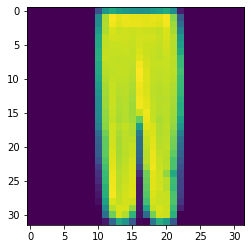

In [127]:
plt.imshow(next(di)[0].numpy().squeeze())

In [131]:
sum(torch.bernoulli(0.5 * torch.ones(500)))

tensor(264.)

<ipython-input-38-4bb7bd26e3d6>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


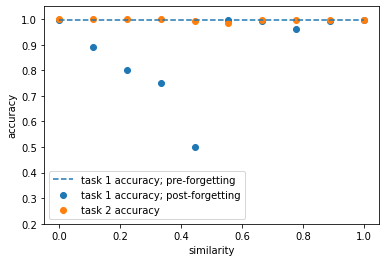

In [38]:
fig = plt.figure()
plt.scatter(task_1_accuracies.keys(), task_1_accuracies.values(), label="task 1 accuracy; post-forgetting")
plt.scatter(task_2_accuracies.keys(), task_2_accuracies.values(), label="task 2 accuracy")
plt.plot([0, 1], [0.997, 0.997], linestyle="dashed", label="task 1 accuracy; pre-forgetting")
plt.legend()
plt.xlabel("similarity")
plt.ylabel("accuracy")
plt.ylim((0.2, 1.05))
fig.show()
fig.savefig("ramamesh_replica.pdf", dpi=50)

In [ ]:
fig = plt.figure()
plt.plot(task_1_accuracies.keys(), task_1_accuracies.values())
plt.plot(task_2_accuracies.keys(), task_2_accuracies.values())
fig.show()